# Assignment III - NLP: Seinfeld or Friends?

### By: Dalia Smyrnov & Michael Rubinfeld



In this assignment we will create a deep learning model that could identify whether a line was taken from a Seinfeld episode or a Friends episode.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20III/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20III/test.csv')

## EDA

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

#### Representations of the shows and it's characters in the data

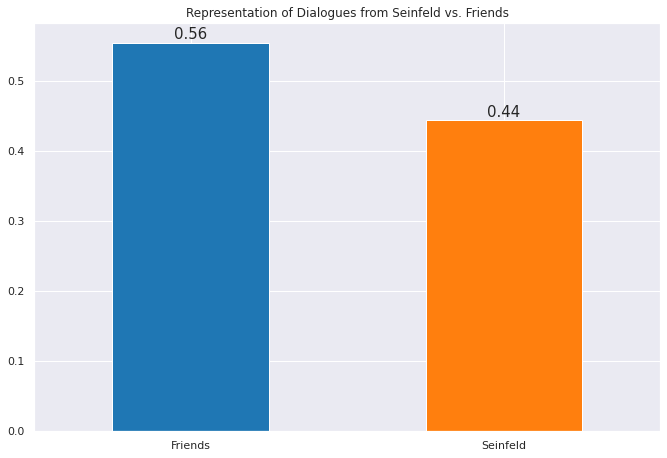

In [ ]:
plt.figure(figsize=(10,7))
bars = train['Show'].value_counts() / len(train)
sns.set(style="darkgrid")
ax = bars.plot(kind = 'bar', color=colors)
plt.xticks(rotation=360)
plt.title('Representation of Dialogues from Seinfeld vs. Friends')
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2,
                p.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

Pretty well distributed, we don't expect to face imbalanced data challenges to solve in this exercise.

Giddy up!

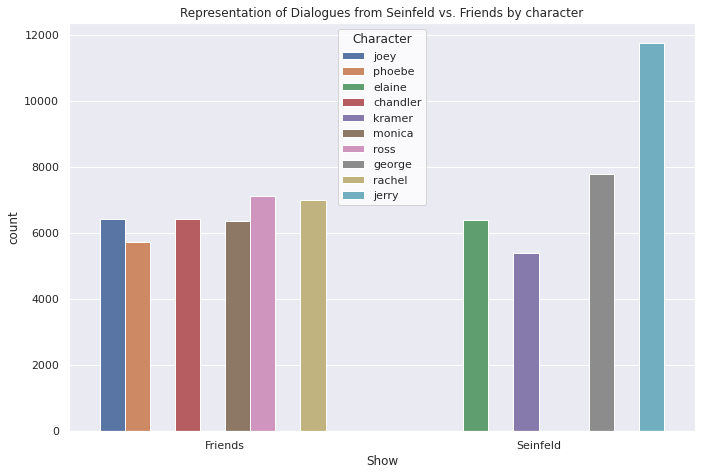

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Representation of Dialogues from Seinfeld vs. Friends by character')
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Show", data=train, hue='Character')
sns.move_legend(ax, "upper center")

Interesting to see that in "Friends" the show is focused on all 6 of them, and in Seinfeld, Jerry has by far the most dialogue while Kramer has the least. This makes sense, since his humor has a lot slapstick.

#### Looking at more segmentations of the data
Let's see how well represented each season is in each show.

In [ ]:
def get_season_number(dialogue):
  return int(re.findall(r'\d+', dialogue)[0])

train['Season'] = train.Episode.map(lambda x: get_season_number(x))
train

,Dialogue,Character,Episode,Show,Dialogue_length,Season
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1,7
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13,10
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14,3
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56,2
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13,5
...,...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2,5
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22,3
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9,5


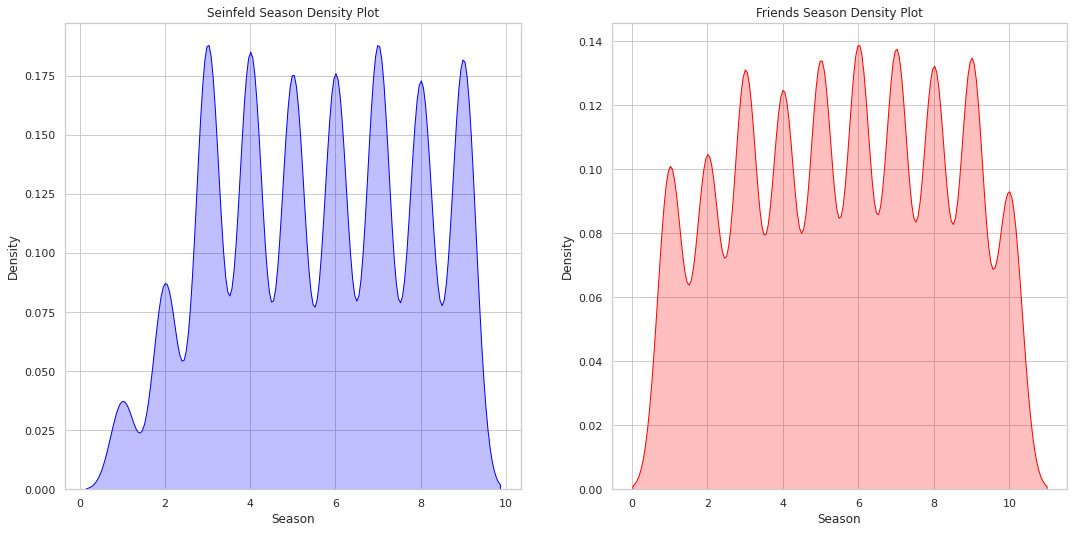

In [ ]:
seinfeld_data = train.loc[train['Show'] == 'Seinfeld']
friends_data = train.loc[train['Show'] != 'Seinfeld']

figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(16,8)
sns.set(style="darkgrid")
sns.kdeplot(seinfeld_data['Season'], shade = True, ax=ax1, color='blue')
sns.kdeplot(friends_data['Season'], shade = True, ax=ax2, color='red')
ax1.set_title('Seinfeld Season Density Plot')
ax2.set_title('Friends Season Density Plot')
plt.show()

We can see that the seasons are somewhat evenly distributed in both shows, Except of Seinfeld's first two. It makes since because they were shorter (and not as insanely good as the rest of the show).

Now let's segment the data by words in the dialogue and see if we find interesting patterns.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

def make_wordcloud(df, plot_name):
  cv = CountVectorizer(stop_words = 'english')
  words = cv.fit_transform(df['Dialogue'])
  sum_words = words.sum(axis=0)

  words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

  wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(wordcloud)
  plt.title(plot_name, fontsize = 20)
  plt.show()

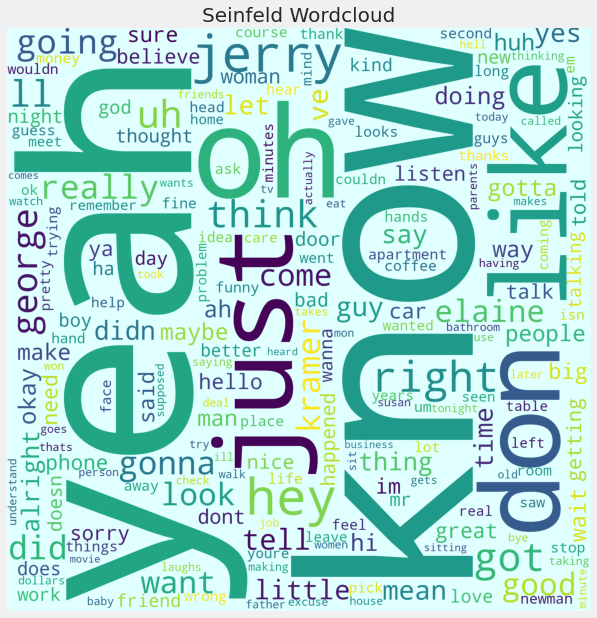

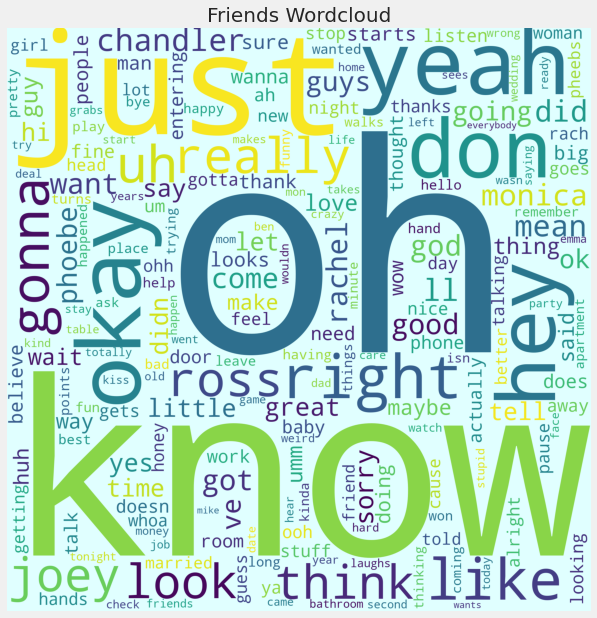

In [ ]:
make_wordcloud(seinfeld_data, 'Seinfeld Wordcloud')
print('\n\n\n')
make_wordcloud(friends_data, 'Friends Wordcloud')

Not recognizing any interesting patterns. We can see both show's character names present.

## Text Data Normalization

Let's see some of the data:

In [ ]:
print(train['Dialogue'][0])
print(train['Dialogue'][1])
print(train['Dialogue'][2])
print(train['Dialogue'][3])
print(train['Dialogue'][4])

 Hey.
 (to Joey) Are you gonna be embarrassed going up there having nothing prepared?
Me? No no no, you. You're gonna tell him. I'm not gonna tell- Noo.
 Alright you guys are off to party number one [ushers 3 guys into Monica's apartment] and you, you are off to party number two [ushers four women into his apartment. Two guys try to follow and Chandler blocks them and shoos them off to Monica's apartment] Alright fellas, let's keep it movin', let' keep it movin.
Am I? Or am I so sane that you just blew your mind?


We can see that there is extra information about the scene that's not part of the dialogue (inside paranthesis and brackets) so we need to get rid of it besides other obvious normalization strategies (removing special chars, separating shortcuts, stemming and removing stopwords).

Other than that, we don't see any other special cases.

In [ ]:
def normalize_data(df):

    def remove_non_dialogue_text(text):
      return re.sub("[\(\[].*?[\)\]]", "", text)

    def remove_unexpected_chars(text):
      unexpected_re = re.compile(r"[^A-Za-z0-9^,!.\/'+-=]>")
      return unexpected_re.sub('', text)

    def english_shortcut_corrections(text):
        text = text.replace(r"?", "")
        text = text.replace(r"'s", " is")
        text = text.replace(r"ive", "I have")
        text = text.replace(r"didnt", "did not")
        text = text.replace(r"heyy", "hey")
        text = text.replace(r"'ve", " have")
        text = text.replace(r"can't", "cannot")
        text = text.replace(r"cant", "cannot")
        text = text.replace(r"musn't", "must not")
        text = text.replace(r"you're", "you are")
        text = text.replace(r"youre", "you are")
        text = text.replace(r"they're", "they are")
        text = text.replace(r"theyre", "they are")
        text = text.replace(r"yup", "yes")
        text = text.replace(r"n't", " not")
        text = text.replace(r"i'm", "I am")
        text = text.replace(r"im", "I am")
        text = text.replace(r"IM", "I am")
        text = text.replace(r"Im", "I am")
        text = text.replace(r"I'm", "I am")
        text = text.replace(r"'re", " are")
        text = text.replace(r"'d", " would")
        text = text.replace(r"\'ll", " will")
        text = text.replace(r"I'm", "I am")
        text = text.replace(r"\em", "them")

        return text

    # relevant punctuations: whitespace, exclamation-mark and question-mark
    def remove_irrelevant_punctuations(text):
        return re.sub(pattern='[^\w\s\!\?]', repl='', string=text)

    # almost last to limit noise in the text so the function will successfully stem most words
    def stem_words(text):
        words = text.split()
        stemmer = SnowballStemmer(language='english')
        stemmed_text = ''
        for word in words:
            x = stemmer.stem(word)
            stemmed_text += x + ' '
        return stemmed_text.rstrip()

    # saved for last because the text has to be as clean as possible for this function to catch the most stopwords
    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        return ' '.join(word for word in text.split() if word.lower() not in stop_words)

    # apply all functions (order is important) and after strip leftover whitspaces
    df['Dialogue'] = df.Dialogue.map(lambda x: x.lower())
    df['Dialogue'] = df.Dialogue.map(lambda x: remove_non_dialogue_text(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: remove_unexpected_chars(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: english_shortcut_corrections(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: remove_irrelevant_punctuations(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: stem_words(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: remove_stopwords(x))
    df['Dialogue'] = df.Dialogue.map(lambda x: x.strip())

    return df

Now, we will apply the normalizer on both the train and test sets: 

In [ ]:
train_copy = train.copy()
train_normalized = normalize_data(train)
test_normalized = normalize_data(test)

In [ ]:
print('Train before:')
print(train_copy['Dialogue'].head(10))
print('\n\n\n')
print('Train After:')
print(train_normalized['Dialogue'].head(10))

Train before:
0                                                 Hey.
1     (to Joey) Are you gonna be embarrassed going ...
2    Me? No no no, you. You're gonna tell him. I'm ...
3     Alright you guys are off to party number one ...
4    Am I? Or am I so sane that you just blew your ...
5     So, if you’re parents hadn’t got divorced, yo...
6                                           What's up?
7     (over-enthusiastic) I don't know, I don' I do...
8     I know. *He* always wanted to be the first bl...
9                   This uniform, what's it made from?
Name: Dialogue, dtype: object




Train After:
0                                                  hey
1                       gonna embarrass go noth prepar
2                         gonna tell hi gonna tell noo
3    alright guy parti number one parti number two ...
4                                       sane blew mind
5    parent hadnt got divorc youd abl answer questi...
6                                                     
7   

## Modeling

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# 1 = Seinfeld, 0 = Friends

X_train_val = train_normalized['Dialogue']
y_train_val = pd.get_dummies(train_normalized['Show'])['Seinfeld']


X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values, 
                                                  shuffle=True, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train.shape)

(56324,)
(14081,)
(14081,)
(56324,)


#### Yada, yada, yada... Here's the model

In [ ]:
MAX_WORDS = max(train['Dialogue_length'])
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)
total_words = len(token.word_index) + 1

In [ ]:
X_train_sequences = token.texts_to_sequences(X_train)
X_val_sequences = token.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_WORDS)
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_WORDS)

#### First Try: 

We wanted to see how well a convolutional model does, similar to what was taught in class:

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=MAX_WORDS))
model.add(Conv1D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=7)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7,
                                                 verbose=1)

history = model.fit(x=X_train_padded, y=y_train, epochs=100, batch_size=32, validation_data=(X_val_padded, y_val),
                    callbacks=[es, reduce_lr], verbose=1, shuffle=True)


Epoch 1/100
1761/1761 [==============================] - 33s 11ms/step - loss: 0.6403 - accuracy: 0.6056 - val_loss: 0.5520 - val_accuracy: 0.7007 - lr: 1.0000e-04
Epoch 2/100
1761/1761 [==============================] - 13s 7ms/step - loss: 0.5230 - accuracy: 0.7252 - val_loss: 0.5099 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 3/100
1761/1761 [==============================] - 10s 6ms/step - loss: 0.4734 - accuracy: 0.7597 - val_loss: 0.4956 - val_accuracy: 0.7384 - lr: 1.0000e-04
Epoch 4/100
1761/1761 [==============================] - 10s 6ms/step - loss: 0.4429 - accuracy: 0.7790 - val_loss: 0.4941 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 5/100
1761/1761 [==============================] - 10s 6ms/step - loss: 0.4223 - accuracy: 0.7899 - val_loss: 0.4955 - val_accuracy: 0.7403 - lr: 1.0000e-04
Epoch 6/100
1761/1761 [==============================] - 10s 6ms/step - loss: 0.4069 - accuracy: 0.7978 - val_loss: 0.5032 - val_accuracy: 0.7379 - lr: 1.0000e-04
Epoch 7/100
1755/1761

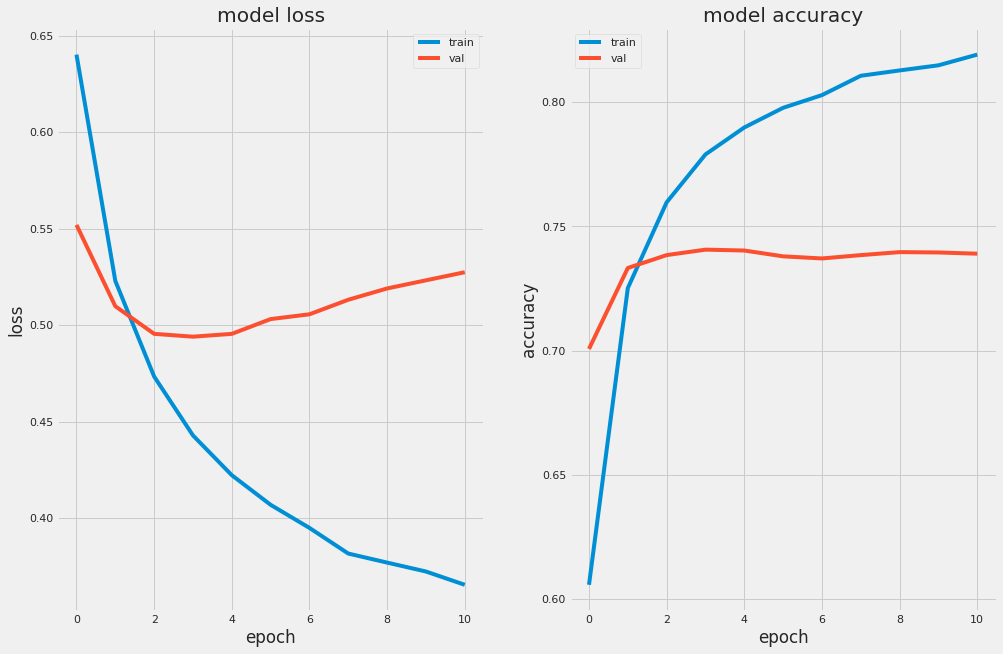

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2) # index 2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

Validation accuracy is OK but the model started overfitting after only 2 epochs!

#### Second Try: LSTM
Secondly, we wanted to try using an LSTM layer and see if we get better results.

In [ ]:
from tensorflow.keras.layers import LSTM, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=MAX_WORDS))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(32, dropout=0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=7)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7,
                                                 verbose=1)

history = model.fit(x=X_train_padded, y=y_train, epochs=30, batch_size=128, validation_data=(X_val_padded, y_val),
                    callbacks=[es, reduce_lr], verbose=1, shuffle=True)


Epoch 1/30
441/441 [==============================] - 12s 22ms/step - loss: 0.6875 - accuracy: 0.5516 - val_loss: 0.6828 - val_accuracy: 0.5552 - lr: 1.0000e-04
Epoch 2/30
441/441 [==============================] - 11s 25ms/step - loss: 0.6736 - accuracy: 0.5619 - val_loss: 0.6579 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 3/30
441/441 [==============================] - 8s 19ms/step - loss: 0.6375 - accuracy: 0.6053 - val_loss: 0.6143 - val_accuracy: 0.6555 - lr: 1.0000e-04
Epoch 4/30
441/441 [==============================] - 9s 20ms/step - loss: 0.5875 - accuracy: 0.6698 - val_loss: 0.5621 - val_accuracy: 0.7026 - lr: 1.0000e-04
Epoch 5/30
441/441 [==============================] - 8s 18ms/step - loss: 0.5547 - accuracy: 0.6994 - val_loss: 0.5415 - val_accuracy: 0.7124 - lr: 1.0000e-04
Epoch 6/30
441/441 [==============================] - 9s 19ms/step - loss: 0.5423 - accuracy: 0.7093 - val_loss: 0.5336 - val_accuracy: 0.7151 - lr: 1.0000e-04
Epoch 7/30
441/441 [==================

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 363, 32)           516768    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 363, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
 activation_15 (Activation)  (None, 1)                 0         
                                                                 
Total params: 525,121
Trainable params: 525,121
Non-trainable params: 0
________________________________________________

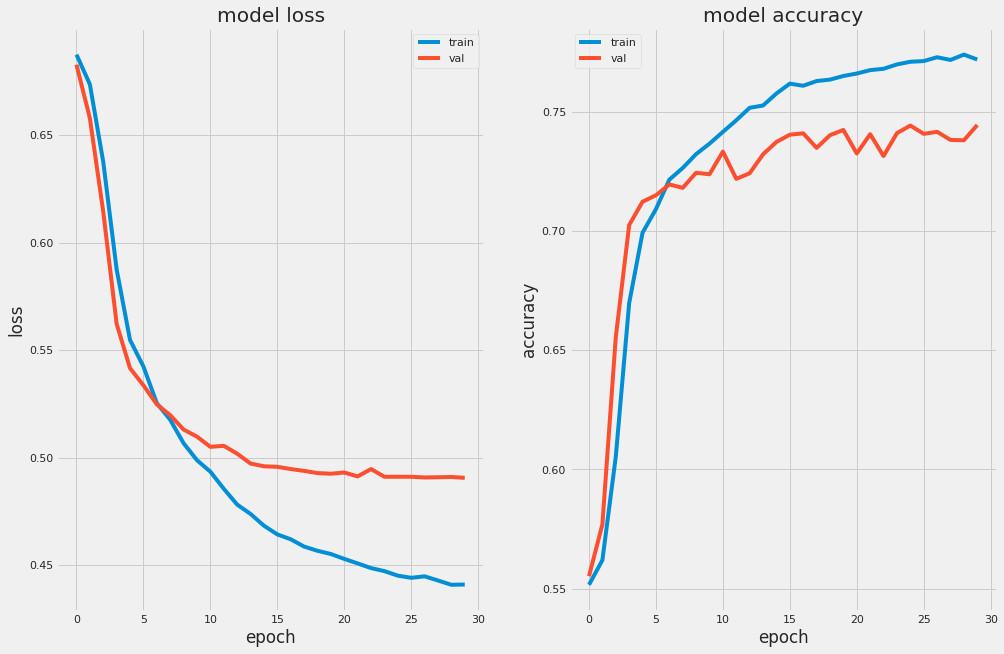

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2) # index 2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

Nice training graph!

Looks like this model is "master of it's domain"!

#### Training Results

In [ ]:
X_test = test_normalized['Dialogue']
y_test = pd.get_dummies(test_normalized['Show'])['Seinfeld']

X_train_val_sequences = token.texts_to_sequences(X_train_val)
X_train_val_padded = pad_sequences(X_train_val_sequences, maxlen=MAX_WORDS)

X_test_sequences = token.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_WORDS)

_, nlp_model_train_acc = model.evaluate(X_train_val_padded, y_train_val, verbose=0)
_, nlp_model_test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
print('MODEL TRAINING RESULTS:')
print(f'Train accuracy of LSTM model: {nlp_model_train_acc}')
print(f'Test accuracy of LSTM model: {nlp_model_test_acc}')

MODEL TRAINING RESULTS:
Train accuracy of LSTM model: 0.7844045162200928
Test accuracy of LSTM model: 0.8360424041748047


#### Training results per character

In [ ]:
character_acc_results_dict = {}
characters = train_normalized['Character'].unique()

for character in characters:
  character_test_df = test_normalized.loc[test_normalized['Character'] == character]
  X_test = character_test_df['Dialogue']
  y_test = character_test_df['Show'].map({'Seinfeld': 1, 'Friends' : 0})
  X_test_sequences = token.texts_to_sequences(X_test)
  X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_WORDS)

  _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
  
  character_acc_results_dict[character] = acc

In [ ]:
character_acc_results_df = pd.DataFrame.from_dict(character_acc_results_dict,
                                                  orient='index', columns=['Test Accuracy Score Per Character'])
character_acc_results_df = character_acc_results_df.sort_values(
    by='Test Accuracy Score Per Character', ascending=False)

character_acc_results_df = character_acc_results_df.merge(train[['Character', 'Show']], left_index=True, right_on='Character', how='left')
character_acc_results_df.drop_duplicates('Character').set_index('Character')

,Test Accuracy Score Per Character,Show
Character,,
phoebe,0.883249,Friends
monica,0.876963,Friends
ross,0.875789,Friends
rachel,0.867965,Friends
kramer,0.837838,Seinfeld
joey,0.836864,Friends
chandler,0.815085,Friends
jerry,0.812606,Seinfeld
george,0.784810,Seinfeld


We can see that the model did better on Friends characters than Seinfeld. A possible explanation is the fact that Seinfeld has a way smarter script and the dialogue is not as predictable as in Friends.

In [ ]:
results = {'model': ['NLP Model'],
              'Test score (Accuracy)': nlp_model_test_acc,
              'Train score (Accuracy)': nlp_model_train_acc,
              'Embedding Dim': 32,
              'Number of trainable parameters': 525121,
              'Number of layers': 4,
              'Regularization methods': 'SpatialDropout1D and regular Dropout',
              'Number of epochs': 30,
              'Loss function': 'binary_crossentropy',
              'Optimizer': 'Adam'
              }

results_df = pd.DataFrame(results)
results_df

,model,Test score (Accuracy),Train score (Accuracy),Embedding Dim,Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,NLP Model,0.836042,0.784405,32,525121,4,SpatialDropout1D and regular Dropout,30,binary_crossentropy,Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_to_save = 'drive/My Drive/EX3_MICHAEL_RUBINFELD_AND_DALIA_SMYRNOV/exercise3.csv'
results_df.to_csv(path_to_save)

Mounted at /content/drive
